In [1]:
import datetime as dt
import pandas as pd
from matplotlib import pyplot as plt
import utils
from scipy.optimize import minimize
import numpy as np
from sklearn.metrics import confusion_matrix

# Reading in Data

In [2]:
# Reading in the dataframe and converting to dates and floats
btc_df = pd.read_csv("Data.csv", index_col=0, parse_dates=True)
btc_df["price"] = btc_df["price"].str.replace(",", "").astype(float)
btc_df["price_diff"] = btc_df["price"] - btc_df["price"].shift(1)
btc_ar = btc_df.values

# Verifying that no days are missing in the model
assert all(btc_df.index.to_series() == pd.date_range(start="2020-04-25", end="2025-10-15"))

In [3]:
def get_df():
    # A function that returns the bitcoin dataframe
    btc_df = pd.read_csv("Data.csv", index_col=0, parse_dates=True)
    btc_df["price"] = btc_df["price"].str.replace(",", "").astype(float)
    btc_df["price_diff"] = btc_df["price"] - btc_df["price"].shift(1)
    return btc_df

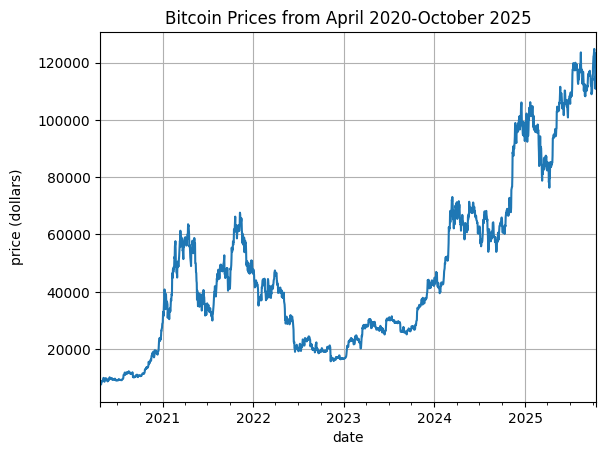

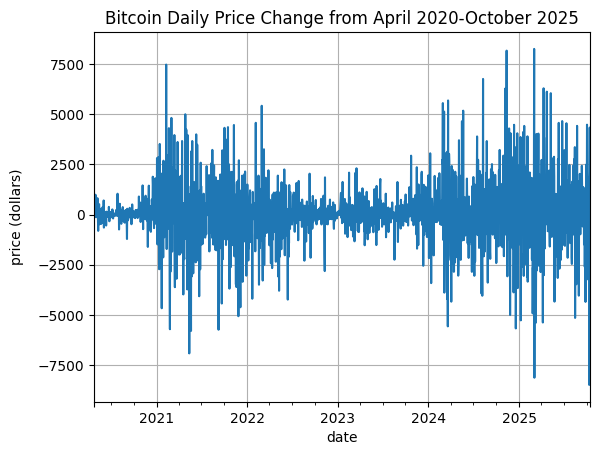

In [4]:
# Plotting the initial bitcoin data
ax = btc_df["price"].plot()
plt.title("Bitcoin Prices from April 2020-October 2025")
plt.ylabel("price (dollars)", labelpad=10)
plt.grid(True)
plt.savefig("Pictures/price_data.png", dpi=300, bbox_inches="tight")
plt.show()

# Plotting the daily price change feature
ax = btc_df["price_diff"].plot()
plt.title("Bitcoin Daily Price Change from April 2020-October 2025")
plt.ylabel("price (dollars)", labelpad=10)
plt.grid(True)
plt.savefig("Pictures/price_diff_data.png", dpi=300, bbox_inches="tight")
plt.show()

# Summary Statistics

In [5]:
# Computing the frequency at which prices rose between days
print(sum(btc_df["price_diff"] > 0) / len(btc_df))

# Determining the average change when prices go up and when they go down
print(btc_df[btc_df["price_diff"] > 0]["price_diff"].mean())
print(btc_df[btc_df["price_diff"] < 0]["price_diff"].mean())

# Determining general summary statistics
btc_df.describe()

0.515
979.6713203883497
-932.3016305469556


,price,price_diff
count,2000.000000,1999.000000
mean,47525.415810,52.857019
std,29942.095085,1498.785259
min,7495.390000,-8496.290000
25%,23823.277500,-469.650000
50%,40508.710000,22.700000
75%,63346.122500,586.215000
max,124773.510000,8256.270000


# Autoregressive Linear Regression

## First Autoregressive Model Experiment

Here we'll try to model the future price based on two days; one from a week ago and one from a month ago.

In [6]:
def build_guess_column(params, df, shifts, col_name="price", est_name="estimation_column"):
    """
    Adds a new column to the input dataframe that builds the estimated values out of linear transformations of shifted columns.
    """
    df = df.copy()
    df[est_name] = sum([params[i] * df[col_name].shift(shift) for i, shift in enumerate(shifts)])
    return df

In [7]:
def compute_loss(params, df, shifts, col_name="price", est_name="estimation_column"):
    """
    Computes the loss for a guess. Uses mean-squares as the loss function.
    """
    est_df = build_guess_column(params, df, shifts, col_name=col_name, est_name=est_name)
    diff = (est_df[col_name] - est_df[est_name])**2
    return diff.sum()

Optimal exposures: [ 0.94936922  0.06627886  0.00504538 -0.00223336  0.01045524 -0.02552327
 -0.01487363 -0.04742145  0.09913483 -0.02169876  0.00595487 -0.06619649
  0.08707169 -0.02786847 -0.03838983 -0.0040929   0.03901699 -0.02885578
 -0.02289407  0.02440206  0.01040179 -0.00232177 -0.03107474  0.08208754
 -0.0010144  -0.02101166  0.0364133   0.00309735 -0.08571681  0.02238985]
Optimal loss:      2583529487.1844454


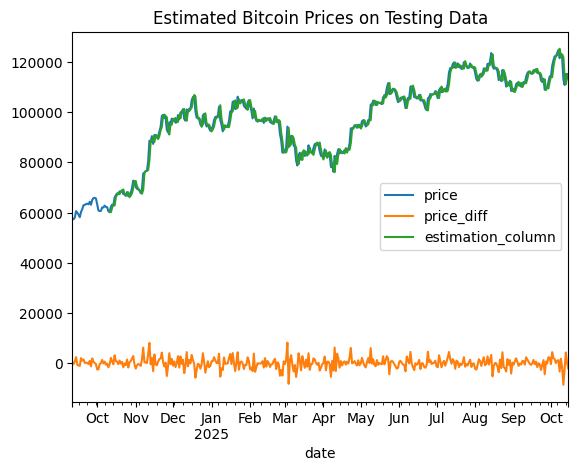

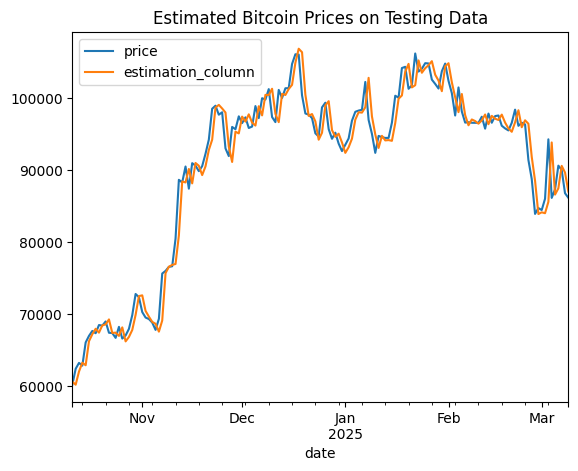

In [8]:
# Making a train-test split
n = len(btc_df)
btc_df_train, btc_df_test = btc_df.iloc[:int(0.8*n)], btc_df.iloc[int(0.8*n):]

# Training the coefficients
shifts = list(range(1, 31, 1))
x0 = [1 for _ in range(len(shifts))]
result = minimize(compute_loss, x0, args=(btc_df_train, shifts))

print(f"Optimal exposures: {result.x}")
print(f"Optimal loss:      {result.fun}")

# Graphing the daily guesses
params = result.x

est_df = build_guess_column(params, btc_df_test, shifts)
est_df.plot()
plt.title("Estimated Bitcoin Prices on Testing Data")
plt.show()

est_df.iloc[max(shifts):max(shifts) + 150][["price", "estimation_column"]].plot()
plt.title("Estimated Bitcoin Prices on Testing Data")
plt.savefig("Pictures/autoregressive_price_estimation.png", dpi=300, bbox_inches="tight")
plt.show()

## Experimenting on daily returns instead of daily prices

Optimal exposures: [-0.05087598  0.01644561  0.02134053  0.01869494  0.02947973  0.00396587
 -0.01193208 -0.05898183  0.04012078  0.01845713  0.02409258 -0.04187073
  0.04544464  0.01696844 -0.0212044  -0.02475551  0.01482633 -0.01530684
 -0.03736527 -0.01317358 -0.00244813 -0.00595367 -0.03645996  0.04584267
  0.04530389  0.02398921  0.0604826   0.06343328 -0.02307486 -0.01253632]
Optimal loss:      2582944080.3900905


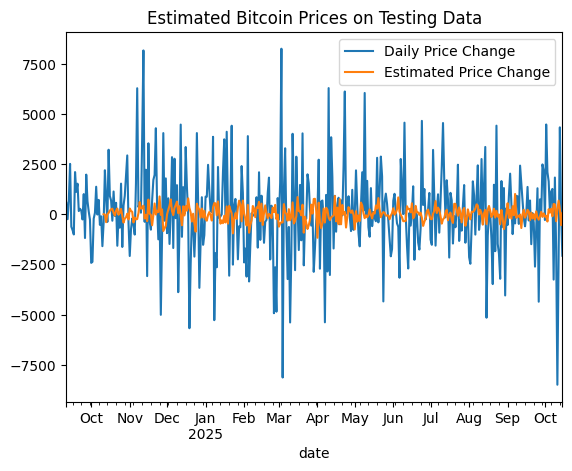

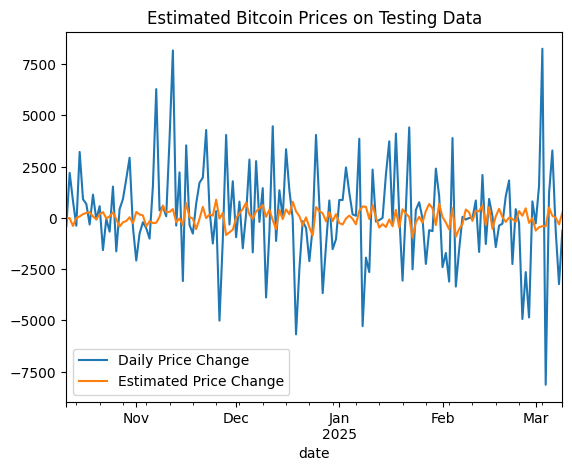

In [9]:
# Making a returns df
ret_df = get_df()
ret_df.drop(columns="price", inplace=True)

# Making a train-test split
n = len(ret_df)
ret_df_train, ret_df_test = ret_df.iloc[:int(0.8*n)], ret_df.iloc[int(0.8*n):]

# Training the coefficients
shifts = list(range(1, 31, 1))
x0 = [1 for _ in range(len(shifts))]
result = minimize(compute_loss, x0, args=(ret_df_train, shifts, "price_diff", "est_price_diff"))

print(f"Optimal exposures: {result.x}")
print(f"Optimal loss:      {result.fun}")

# Graphing the daily guesses
params = result.x

ret_est_df = build_guess_column(params, ret_df_test, shifts, "price_diff", "est_price_diff")
ret_est_df.plot()
plt.title("Estimated Bitcoin Prices on Testing Data")
plt.legend(labels=["Daily Price Change", "Estimated Price Change"])
plt.show()

ret_est_df.iloc[max(shifts):max(shifts) + 150].plot()
plt.title("Estimated Bitcoin Prices on Testing Data")
plt.legend(labels=["Daily Price Change", "Estimated Price Change"])
plt.savefig("Pictures/autoregressive_price_fail.png", dpi=300, bbox_inches="tight")
plt.show()

In [28]:
# Computing the confusion matrix and other summary stats
print(f"Correct Classification Rate: ", end="")
print(sum(np.sign(ret_est_df["price_diff"]).iloc[30:] == np.sign(ret_est_df["est_price_diff"]).iloc[30:]) / len(ret_est_df["price_diff"].iloc[30:]))

cm = confusion_matrix(np.sign(ret_est_df["price_diff"]).iloc[30:], np.sign(ret_est_df["est_price_diff"]).iloc[30:], normalize="true")
print(cm)

Correct Classification Rate: 0.5108108108108108
[[0.49162011 0.50837989]
 [0.47120419 0.52879581]]


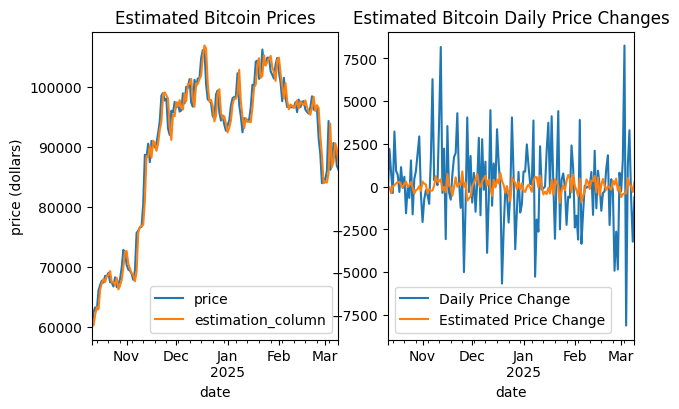

In [11]:
# Making a combined graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))
est_df.iloc[max(shifts):max(shifts) + 150][["price", "estimation_column"]].plot(ax=ax1)
ax1.set_title("Estimated Bitcoin Prices")
# plt.savefig("Pictures/autoregressive_price_estimation.png", dpi=300, bbox_inches="tight")
ax1.set_ylabel("price (dollars)")

ret_est_df.iloc[max(shifts):max(shifts) + 150].plot(ax=ax2)
plt.title("Estimated Bitcoin Daily Price Changes")
plt.legend(labels=["Daily Price Change", "Estimated Price Change"])
# plt.savefig("Pictures/autoregressive_price_fail.png", dpi=300, bbox_inches="tight")
plt.show()

## Determining the day with the greatest predictive power

In [12]:
# Making a returns df
ret_df = get_df()
ret_df.drop(columns="price", inplace=True)

# Making a train-test split
n = len(ret_df)
ret_df_train, ret_df_test = ret_df.iloc[:int(0.8*n)], ret_df.iloc[int(0.8*n):]

# Training the coefficients
optimal_shift = None
optimal_loss = float("inf")
for shift in range(1, 100):
    x0 = [1]
    result = minimize(compute_loss, x0, args=(ret_df_train, [shift], "price_diff", "est_price_diff"))

    # Determining the loss
    if result.fun < optimal_loss:
        optimal_shift = shift
        optimal_loss = result.fun

print(f"Optimal loss: {optimal_loss}")
print(f"Optimal shift: {optimal_shift}")

Optimal loss: 2652783907.033593
Optimal shift: 60


# Trees & Random Forests

In [13]:
import argparse
import math
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Callable, Dict, Iterable, List, Optional, Tuple

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    ExtraTreesClassifier,
    ExtraTreesRegressor,
)
plt.style.use("ggplot")


In [ ]:
# Loads the price dataframe and computes daily returns and a few other stats
def load_price_data(csv_path: str = "Data.csv") -> pd.DataFrame:
    """Load Data.csv -> DataFrame indexed by date with float price."""
    df = pd.read_csv(csv_path)
    date_col = next((c for c in df.columns if c.lower() == "date"), None)
    price_col = next((c for c in df.columns if c.lower() == "price"), None)

    # Verifying that we read in the expected data
    if price_col is None:
        raise ValueError("Expected a 'price' column in Data.csv")
    df[price_col] = (
        df[price_col]
        .astype(str)
        .str.replace(",", "")
        .astype(float)
    )

    # If we have a date column, convert it to a pandas datetime type
    if date_col:
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
        df = df.sort_values(date_col).set_index(date_col)

    # Computing other metrics
    df["return"] = df[price_col].pct_change()
    df["log_return"] = np.log(df[price_col]).diff()
    df["future_return"] = df["return"].shift(-1)
    df = df.dropna().copy()
    return df.rename(columns={price_col: "price"})


In [ ]:
# Computing a few different features for testing purposes
def build_features(
    df: pd.DataFrame,
    feature_set: str,
    n_lags: int = 5,
    roll_mean: int = 5,
    roll_vol: int = 20,
) -> pd.DataFrame:
    """Return feature matrix + targets for a given feature_set (A/B/C)."""
    feats = pd.DataFrame(index=df.index)
    for lag in range(1, n_lags + 1):
        feats[f"lag_ret_{lag}"] = df["return"].shift(lag)
    if feature_set in {"B", "C"}:
        feats["roll_mean"] = df["return"].rolling(roll_mean).mean()
        feats["roll_vol"] = df["return"].rolling(roll_vol).std()
    if feature_set == "C":
        dow = df.index.dayofweek
        month = df.index.month
        feats["dow_sin"] = np.sin(2 * np.pi * dow / 7)
        feats["dow_cos"] = np.cos(2 * np.pi * dow / 7)
        feats["month_sin"] = np.sin(2 * np.pi * month / 12)
        feats["month_cos"] = np.cos(2 * np.pi * month / 12)
    feats["target_reg"] = df["future_return"]
    feats["target_cls"] = (df["future_return"] > 0).astype(int)
    feats["price"] = df["price"]
    feats["future_return_raw"] = df["future_return"]
    feats = feats.dropna()
    return feats

In [ ]:
# Getting the train-test split
def chronological_split(
    df: pd.DataFrame, train_frac: float = 0.7, val_frac: float = 0.15
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Chronological train/val/test split."""
    n = len(df)
    t = int(train_frac * n)
    v = int(val_frac * n)
    train = df.iloc[:t]
    val = df.iloc[t : t + v]
    test = df.iloc[t + v :]
    return train, val, test

In [ ]:
# This is used for quickly estimating statistics by grabbing data semi-randomly from blocks in the dataframe
def moving_block_bootstrap(
    df: pd.DataFrame, block_size: int, rng: np.random.Generator
) -> pd.DataFrame:
    """Time-series block bootstrap (moving blocks)."""
    if block_size <= 1:
        return df.copy()
    n = len(df)

    # Randomly grabbing data from each block
    if n <= block_size:
        idx = rng.choice(n, size=n, replace=True)
        return df.iloc[idx].copy()
    idx: List[int] = []
    while len(idx) < n:
        start = rng.integers(0, n - block_size + 1)
        idx.extend(range(start, start + block_size))
    
    # Returning the results
    return df.iloc[idx[:n]].copy()

In [ ]:
def max_drawdown(equity: pd.Series) -> float:
    # Comparing the current price to the maximum price up to that point
    peak = equity.cummax()
    dd = (equity - peak) / peak
    return float(dd.min())

In [19]:
@dataclass
class ProfitMetrics:
    total_return: float
    sharpe: float
    max_drawdown: float
    win_rate: float
    equity: pd.Series
    pnl: pd.Series

def simulate_trading(
    returns: pd.Series,
    preds: np.ndarray,
    rule: str,
    threshold: float,
    transaction_cost: float,
    position_cap: float = 1.0,
) -> ProfitMetrics:
    """Apply trading rule to predictions and compute profit metrics."""
    preds = np.asarray(preds).reshape(-1)
    signals = np.zeros_like(preds, dtype=float)
    if rule == "binary":
        signals[preds > threshold] = 1.0
    elif rule == "prob":
        signals[preds >= threshold] = 1.0
    elif rule == "proportional":
        scale = np.tanh(preds)
        max_abs = np.max(np.abs(scale)) if len(scale) else 0
        if max_abs > 0:
            scale = scale / max_abs
        signals = np.clip(scale, -position_cap, position_cap)
    pnl = signals * returns.values
    changes = np.abs(np.diff(np.insert(signals, 0, 0)))
    pnl -= transaction_cost * changes
    equity = pd.Series(1 + pnl, index=returns.index).cumprod()
    ret = float(equity.iloc[-1] - 1)
    sharpe = 0.0
    if np.std(pnl) > 0:
        sharpe = float(np.mean(pnl) / np.std(pnl) * math.sqrt(252))
    win_rate = float(np.mean(pnl > 0))
    return ProfitMetrics(
        total_return=ret,
        sharpe=sharpe,
        max_drawdown=max_drawdown(equity),
        win_rate=win_rate,
        equity=equity,
        pnl=pd.Series(pnl, index=returns.index),
    )

In [20]:
def regression_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    return {"mae": float(mae), "rmse": float(rmse)}

def classification_metrics(
    y_true: np.ndarray, probs: np.ndarray, threshold: float
) -> Dict[str, Any]:
    pred = (probs >= threshold).astype(int)
    cm = confusion_matrix(y_true, pred)
    metrics = {
        "accuracy": float(accuracy_score(y_true, pred)),
        "precision": float(precision_score(y_true, pred, zero_division=0)),
        "recall": float(recall_score(y_true, pred, zero_division=0)),
        "f1": float(f1_score(y_true, pred, zero_division=0)),
        "confusion_matrix": cm,
    }
    try:
        metrics["roc_auc"] = float(roc_auc_score(y_true, probs))
    except ValueError:
        metrics["roc_auc"] = float("nan")
    return metrics

In [21]:
def plot_equity_curves(curves: Dict[str, pd.Series], title: str, path: Path) -> None:
    plt.figure(figsize=(8, 4))
    for label, eq in curves.items():
        plt.plot(eq.index, eq.values, label=label)
    plt.legend()
    plt.title(title)
    plt.ylabel("Equity")
    plt.xlabel("Date")
    plt.tight_layout()
    plt.savefig(path)
    plt.close()
 
# Is tomorrow up from today?
def plot_profit_box(profits: List[float], title: str, path: Path) -> None:
    plt.figure(figsize=(5, 4))
    plt.boxplot(profits, vert=True, tick_labels=["profit"])
    plt.title(title)
    plt.ylabel("Total return")
    plt.tight_layout()
    plt.savefig(path)
    plt.close()

def plot_scatter(y_true: np.ndarray, y_pred: np.ndarray, title: str, path: Path) -> None:
    plt.figure(figsize=(5, 4))
    plt.scatter(y_true, y_pred, alpha=0.4, s=12)
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(path)
    plt.close()

def _draw_confusion(ax: plt.Axes, cm: np.ndarray, title: Optional[str] = None) -> None:
    """Render a 2x2 confusion matrix with rate labels and no colorbar."""
    cm = np.asarray(cm)
    if cm.shape != (2, 2):
        ax.imshow(cm, cmap="Blues")
        if title:
            ax.set_title(title)
        return
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) else 0.0
    fnr = fn / (fn + tp) if (fn + tp) else 0.0
    tpr = tp / (tp + fn) if (tp + fn) else 0.0
    tnr = tn / (tn + fp) if (tn + fp) else 0.0

    ax.imshow(cm, cmap="Blues", vmin=0)
    labels = [
        (0, 0, f"TN: {tn}\nTNR={tnr:.2f}"),
        (0, 1, f"FP: {fp}\nFPR={fpr:.2f}"),
        (1, 0, f"FN: {fn}\nFNR={fnr:.2f}"),
        (1, 1, f"TP: {tp}\nTPR={tpr:.2f}"),
    ]
    for i, j, text in labels:
        ax.text(j, i, text, ha="center", va="center", fontsize=9, fontweight="bold")

    ax.set_xticks([0, 1], labels=["Pred 0", "Pred 1"])
    ax.set_yticks([0, 1], labels=["Actual 0", "Actual 1"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_aspect("equal")
    ax.grid(False)
    if title:
        ax.set_title(title)
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(1.5, -0.5)

def plot_confusion(cm: np.ndarray, title: str, path: Path, ax: Optional[plt.Axes] = None) -> None:
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    _draw_confusion(ax, cm, title=title)
    if fig is not None:
        fig.tight_layout()
        fig.savefig(path)
        plt.close(fig)

def plot_threshold_scan(thresholds: np.ndarray, profits: np.ndarray, title: str, path: Path) -> None:
    plt.figure(figsize=(6, 4))
    plt.plot(thresholds, profits, marker="o")
    plt.xlabel("Threshold")
    plt.ylabel("Profit")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(path)
    plt.close()

def plot_feature_importance(
    importances: np.ndarray, feature_names: List[str], title: str, path: Path
) -> None:
    order = np.argsort(importances)[::-1]
    plt.figure(figsize=(6, 4))
    plt.bar(range(len(importances)), importances[order])
    plt.xticks(range(len(importances)), np.array(feature_names)[order], rotation=60, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(path)
    plt.close()

def plot_roc_pr(
    y_true: np.ndarray, probs: np.ndarray, title: str, path_roc: Path, path_pr: Path
) -> None:
    fpr, tpr, _ = roc_curve(y_true, probs)
    prec, rec, _ = precision_recall_curve(y_true, probs)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"ROC - {title}")
    plt.tight_layout()
    plt.savefig(path_roc)
    plt.close()

    plt.figure(figsize=(5, 4))
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR - {title}")
    plt.tight_layout()
    plt.savefig(path_pr)
    plt.close()

In [22]:

@dataclass
class ExperimentConfig:
    id: str
    task: str  # "R" or "C"
    feature_set: str  # "A", "B", "C"
    model_builder: Callable[[], Any]
    bootstrap_block: int
    threshold_strategy: str  # "zero", "cost", "fixed", "scan_profit", "f1", "proportional"
    profit_rule: str  # "binary", "prob", "proportional"
    description: str
    trees: Optional[int] = None
    threshold_grid: Optional[np.ndarray] = None
    max_features: Optional[Any] = None
    depth_label: Optional[str] = None
    transaction_cost: float = 0.001
    label_threshold: float = 0.0
    n_bootstrap: int = 20
    position_cap: float = 1.0
    use_oob: bool = False

def experiment_grid(cost: float, n_bootstrap: int) -> List[ExperimentConfig]:
    """Create the tree and forest experiment configs from the grid."""
    configs: List[ExperimentConfig] = [
        ExperimentConfig(
            id="T-R1",
            task="R",
            feature_set="A",
            bootstrap_block=30,
            threshold_strategy="zero",
            profit_rule="binary",
            description="Shallow DecisionTreeRegressor, buy if y_hat>0",
            model_builder=lambda: DecisionTreeRegressor(max_depth=3, random_state=42),
            depth_label="shallow",
            n_bootstrap=n_bootstrap,
        ),
        ExperimentConfig(
            id="T-R2",
            task="R",
            feature_set="B",
            bootstrap_block=30,
            threshold_strategy="cost",
            profit_rule="binary",
            description="Medium depth DecisionTreeRegressor, buy if y_hat>cost",
            model_builder=lambda: DecisionTreeRegressor(
                max_depth=5, min_samples_leaf=5, random_state=42
            ),
            depth_label="medium",
            transaction_cost=cost,
            n_bootstrap=n_bootstrap,
        ),
        ExperimentConfig(
            id="T-R3",
            task="R",
            feature_set="C",
            bootstrap_block=30,
            threshold_strategy="proportional",
            profit_rule="proportional",
            description="Deeper tree with position sizing proportional to y_hat",
            model_builder=lambda: DecisionTreeRegressor(
                max_depth=8, min_samples_leaf=10, random_state=42
            ),
            depth_label="deep",
            position_cap=1.0,
            n_bootstrap=n_bootstrap,
        ),
        ExperimentConfig(
            id="T-C1",
            task="C",
            feature_set="A",
            bootstrap_block=30,
            threshold_strategy="fixed",
            profit_rule="prob",
            description="Shallow DecisionTreeClassifier, tau=0.5",
            model_builder=lambda: DecisionTreeClassifier(max_depth=3, random_state=42),
            depth_label="shallow",
            n_bootstrap=n_bootstrap,
        ),
        ExperimentConfig(
            id="T-C2",
            task="C",
            feature_set="B",
            bootstrap_block=30,
            threshold_strategy="scan_profit",
            profit_rule="prob",
            description="Medium DecisionTreeClassifier, scan tau to maximize profit",
            model_builder=lambda: DecisionTreeClassifier(max_depth=6, random_state=42),
            depth_label="medium",
            threshold_grid=np.linspace(0.1, 0.9, 17),
            n_bootstrap=n_bootstrap,
        ),
        ExperimentConfig(
            id="T-C3",
            task="C",
            feature_set="C",
            bootstrap_block=30,
            threshold_strategy="f1",
            profit_rule="prob",
            description="Deeper DecisionTreeClassifier, tau from F1",
            model_builder=lambda: DecisionTreeClassifier(
                max_depth=10, min_samples_leaf=10, random_state=42
            ),
            depth_label="deep",
            n_bootstrap=n_bootstrap,
        ),
        ExperimentConfig(
            id="RF-R1",
            task="R",
            feature_set="B",
            bootstrap_block=45,
            threshold_strategy="zero",
            profit_rule="binary",
            description="RF regressor 50 trees, small max_features, OOB",
            model_builder=lambda: RandomForestRegressor(
                n_estimators=50,
                max_features=0.3,
                oob_score=True,
                bootstrap=True,
                random_state=42,
                n_jobs=-1,
            ),
            trees=50,
            use_oob=True,
            n_bootstrap=n_bootstrap,
        ),
        ExperimentConfig(
            id="RF-R2",
            task="R",
            feature_set="B",
            bootstrap_block=45,
            threshold_strategy="cost",
            profit_rule="binary",
            description="RF regressor 200 trees, medium max_features, OOB",
            model_builder=lambda: RandomForestRegressor(
                n_estimators=200,
                max_features="sqrt",
                oob_score=True,
                bootstrap=True,
                random_state=42,
                n_jobs=-1,
            ),
            trees=200,
            use_oob=True,
            transaction_cost=cost,
            n_bootstrap=n_bootstrap,
        ),
        ExperimentConfig(
            id="RF-R3",
            task="R",
            feature_set="C",
            bootstrap_block=45,
            threshold_strategy="proportional",
            profit_rule="proportional",
            description="RF regressor 500 trees, strong decorrelation, OOB",
            model_builder=lambda: RandomForestRegressor(
                n_estimators=500,
                max_features=0.2,
                oob_score=True,
                bootstrap=True,
                random_state=42,
                n_jobs=-1,
            ),
            trees=500,
            use_oob=True,
            position_cap=1.0,
            n_bootstrap=n_bootstrap,
        ),
        ExperimentConfig(
            id="RF-C1",
            task="C",
            feature_set="A",
            bootstrap_block=45,
            threshold_strategy="fixed",
            profit_rule="prob",
            description="RF classifier 50 trees, tau=0.5, OOB",
            model_builder=lambda: RandomForestClassifier(
                n_estimators=50,
                max_features="sqrt",
                oob_score=True,
                bootstrap=True,
                random_state=42,
                n_jobs=-1,
            ),
            trees=50,
            use_oob=True,
            n_bootstrap=n_bootstrap,
        ),
        ExperimentConfig(
            id="RF-C2",
            task="C",
            feature_set="B",
            bootstrap_block=45,
            threshold_strategy="scan_profit",
            profit_rule="prob",
            description="RF classifier 200 trees, scan tau on OOB profit",
            model_builder=lambda: RandomForestClassifier(
                n_estimators=200,
                max_features=0.3,
                oob_score=True,
                bootstrap=True,
                random_state=42,
                n_jobs=-1,
            ),
            trees=200,
            use_oob=True,
            threshold_grid=np.linspace(0.1, 0.9, 17),
            n_bootstrap=n_bootstrap,
        ),
        ExperimentConfig(
            id="RF-C3",
            task="C",
            feature_set="C",
            bootstrap_block=45,
            threshold_strategy="f1",
            profit_rule="prob",
            description="RF classifier 500 trees, tau via F1, OOB importance",
            model_builder=lambda: RandomForestClassifier(
                n_estimators=500,
                max_features=0.2,
                oob_score=True,
                bootstrap=True,
                random_state=42,
                n_jobs=-1,
            ),
            trees=500,
            use_oob=True,
            n_bootstrap=n_bootstrap,
        ),
    ]
    return configs

In [23]:
def build_targets_for_threshold(
    df: pd.DataFrame, label_threshold: float
) -> Tuple[np.ndarray, np.ndarray]:
    y_reg = df["target_reg"].values
    y_cls = (df["target_reg"].values > label_threshold).astype(int)
    return y_reg, y_cls

def choose_threshold_by_profit(
    returns: pd.Series,
    probs: np.ndarray,
    grid: np.ndarray,
    cost: float,
    profit_rule: str,
) -> float:
    best_tau = grid[0]
    best_profit = -np.inf
    for tau in grid:
        profit = simulate_trading(
            returns=returns,
            preds=probs,
            rule=profit_rule,
            threshold=tau,
            transaction_cost=cost,
        ).total_return
        if profit > best_profit:
            best_profit = profit
            best_tau = tau
    return float(best_tau)

In [24]:
class ExperimentRunner:
    def __init__(
        self,
        csv_path: str,
        output_dir: str,
        train_frac: float = 0.7,
        val_frac: float = 0.15,
        n_lags: int = 5,
        roll_mean: int = 5,
        roll_vol: int = 20,
        random_seed: int = 123,
    ):
        self.raw = load_price_data(csv_path)
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)
        self.train_frac = train_frac
        self.val_frac = val_frac
        self.n_lags = n_lags
        self.roll_mean = roll_mean
        self.roll_vol = roll_vol
        self.rng = np.random.default_rng(random_seed)
        self.feature_cache: Dict[str, pd.DataFrame] = {}
        self.group_results: List[Dict[str, Any]] = []

    def features(self, feature_set: str) -> pd.DataFrame:
        if feature_set not in self.feature_cache:
            feats = build_features(
                self.raw,
                feature_set=feature_set,
                n_lags=self.n_lags,
                roll_mean=self.roll_mean,
                roll_vol=self.roll_vol,
            )
            self.feature_cache[feature_set] = feats
        return self.feature_cache[feature_set].copy()

    def run_all(self, configs: Iterable[ExperimentConfig]) -> None:
        for cfg in configs:
            print(f"\n=== Running {cfg.id}: {cfg.description}")
            res = self.run_single(cfg)
            if res:
                self.group_results.append(res)
        self._plot_group_equity(task="R", filename="equity_regression.png")
        self._plot_group_equity(task="C", filename="equity_classification.png")
        self._plot_group_profit_box(task="R", filename="profit_box_regression.png")
        self._plot_group_profit_box(task="C", filename="profit_box_classification.png")
        self._plot_group_roc_pr()
        self._plot_group_confusion_matrices()

    def run_single(self, cfg: ExperimentConfig) -> None:
        feats = self.features(cfg.feature_set)
        train_full, val_full, test_full = chronological_split(
            feats, train_frac=self.train_frac, val_frac=self.val_frac
        )
        feature_cols = [c for c in feats.columns if c not in {"target_reg", "target_cls", "price", "future_return_raw"}]
        baseline_equity = (1 + test_full["target_reg"]).cumprod()

        agg_profits: List[float] = []
        agg_mae: List[float] = []
        agg_rmse: List[float] = []
        agg_f1: List[float] = []
        agg_sharpe: List[float] = []
        agg_drawdown: List[float] = []
        agg_win: List[float] = []
        oob_metrics: List[Dict[str, float]] = []

        for b in range(cfg.n_bootstrap):
            boot_rng = np.random.default_rng(self.rng.integers(0, 1_000_000))
            boot_df = moving_block_bootstrap(
                feats, cfg.bootstrap_block, boot_rng
            )
            train, val, test = chronological_split(
                boot_df, train_frac=self.train_frac, val_frac=self.val_frac
            )
            y_reg_train, y_cls_train = build_targets_for_threshold(train, cfg.label_threshold)
            y_reg_val, y_cls_val = build_targets_for_threshold(val, cfg.label_threshold)
            y_reg_test, y_cls_test = build_targets_for_threshold(test, cfg.label_threshold)

            model = cfg.model_builder()
            X_train = train[feature_cols].values
            X_val = val[feature_cols].values
            X_test = test[feature_cols].values

            if cfg.task == "R":
                model.fit(X_train, y_reg_train)
                preds_val = model.predict(X_val)
                preds_test = model.predict(X_test)
                thr = 0.0
                if cfg.threshold_strategy == "cost":
                    thr = cfg.transaction_cost
                elif cfg.threshold_strategy == "zero":
                    thr = 0.0
                elif cfg.threshold_strategy == "proportional":
                    thr = 0.0
                profit_metrics = simulate_trading(
                    returns=test["target_reg"],
                    preds=preds_test,
                    rule=cfg.profit_rule,
                    threshold=thr,
                    transaction_cost=cfg.transaction_cost,
                    position_cap=cfg.position_cap,
                )
                reg_m = regression_metrics(y_reg_test, preds_test)
                agg_mae.append(reg_m["mae"])
                agg_rmse.append(reg_m["rmse"])
                agg_profits.append(profit_metrics.total_return)
                agg_sharpe.append(profit_metrics.sharpe)
                agg_drawdown.append(profit_metrics.max_drawdown)
                agg_win.append(profit_metrics.win_rate)
                if cfg.use_oob and hasattr(model, "oob_prediction_"):
                    oob_pred = np.array(model.oob_prediction_)
                    oob_mask = ~np.isnan(oob_pred)
                    if oob_mask.sum() > 0:
                        oob_metrics.append(
                            regression_metrics(
                                y_reg_train[oob_mask], oob_pred[oob_mask]
                            )
                        )
                if b == 0:
                    plot_scatter(
                        y_reg_test,
                        preds_test,
                        title=f"{cfg.id} true vs pred",
                        path=self.output_dir / f"{cfg.id}_scatter.png",
                    )
            else:
                if len(np.unique(y_cls_train)) < 2:
                    print(f"Skipping bootstrap {b} for {cfg.id}: single-class labels")
                    continue
                model.fit(X_train, y_cls_train)
                prob_val = model.predict_proba(X_val)[:, 1]
                prob_test = model.predict_proba(X_test)[:, 1]
                if cfg.threshold_strategy == "fixed":
                    tau = 0.5
                elif cfg.threshold_strategy == "scan_profit":
                    grid = cfg.threshold_grid if cfg.threshold_grid is not None else np.linspace(0.1, 0.9, 17)
                    tau = choose_threshold_by_profit(
                        returns=val["target_reg"],
                        probs=prob_val,
                        grid=grid,
                        cost=cfg.transaction_cost,
                        profit_rule=cfg.profit_rule,
                    )
                    plot_threshold_scan(
                        grid,
                        np.array(
                            [
                                simulate_trading(
                                    returns=val["target_reg"],
                                    preds=prob_val,
                                    rule=cfg.profit_rule,
                                    threshold=t,
                                    transaction_cost=cfg.transaction_cost,
                                ).total_return
                                for t in grid
                            ]
                        ),
                        title=f"{cfg.id} profit vs tau",
                        path=self.output_dir / f"{cfg.id}_profit_vs_tau.png",
                    )
                elif cfg.threshold_strategy == "f1":
                    grid = cfg.threshold_grid if cfg.threshold_grid is not None else np.linspace(0.1, 0.9, 17)
                    f1s = []
                    for t in grid:
                        f1s.append(
                            classification_metrics(
                                y_true=y_cls_val, probs=prob_val, threshold=t
                            )["f1"]
                        )
                    best_idx = int(np.argmax(f1s))
                    tau = float(grid[best_idx])
                    plot_threshold_scan(
                        grid,
                        np.array(f1s),
                        title=f"{cfg.id} F1 vs tau",
                        path=self.output_dir / f"{cfg.id}_f1_vs_tau.png",
                    )
                else:
                    tau = 0.5
                cls_metrics = classification_metrics(y_cls_test, prob_test, tau)
                profit_metrics = simulate_trading(
                    returns=test["target_reg"],
                    preds=prob_test,
                    rule=cfg.profit_rule,
                    threshold=tau,
                    transaction_cost=cfg.transaction_cost,
                )
                agg_f1.append(cls_metrics["f1"])
                agg_profits.append(profit_metrics.total_return)
                agg_sharpe.append(profit_metrics.sharpe)
                agg_drawdown.append(profit_metrics.max_drawdown)
                agg_win.append(profit_metrics.win_rate)
                if b == 0:
                    plot_confusion(
                        cls_metrics["confusion_matrix"],
                        title=f"{cfg.id} confusion @ tau={tau:.2f}",
                        path=self.output_dir / f"{cfg.id}_cm.png",
                    )
                if cfg.use_oob and hasattr(model, "oob_decision_function_"):
                    oob_probs = model.oob_decision_function_[:, 1]
                    oob_metrics.append(
                        classification_metrics(
                            y_true=y_cls_train,
                            probs=oob_probs,
                            threshold=tau,
                        )
                    )
                if b == 0:
                    plot_roc_pr(
                        y_true=y_cls_test,
                        probs=prob_test,
                        title=cfg.id,
                        path_roc=self.output_dir / f"{cfg.id}_roc.png",
                        path_pr=self.output_dir / f"{cfg.id}_pr.png",
                    )

            if hasattr(model, "feature_importances_") and b == 0:
                plot_feature_importance(
                    model.feature_importances_,
                    feature_names=feature_cols,
                    title=f"{cfg.id} feature importance",
                    path=self.output_dir / f"{cfg.id}_importance.png",
                )

        if not agg_profits:
            print(f"No completed bootstraps for {cfg.id}; skipping summary.")
            return None
        summary: Dict[str, Any] = {
            "id": cfg.id,
            "description": cfg.description,
            "mean_profit": float(np.mean(agg_profits)),
            "median_profit": float(np.median(agg_profits)),
            "mean_sharpe": float(np.mean(agg_sharpe)) if agg_sharpe else float("nan"),
            "mean_drawdown": float(np.mean(agg_drawdown)) if agg_drawdown else float("nan"),
            "mean_win_rate": float(np.mean(agg_win)) if agg_win else float("nan"),
        }
        if cfg.task == "R":
            summary["mean_mae"] = float(np.mean(agg_mae))
            summary["mean_rmse"] = float(np.mean(agg_rmse))
            if oob_metrics:
                summary["oob_mae"] = float(
                    np.mean([m["mae"] for m in oob_metrics if "mae" in m])
                )
                summary["oob_rmse"] = float(
                    np.mean([m["rmse"] for m in oob_metrics if "rmse" in m])
                )
        else:
            summary["mean_f1"] = float(np.mean(agg_f1)) if agg_f1 else float("nan")
            if oob_metrics:
                summary["oob_accuracy"] = float(
                    np.mean([m.get("accuracy", np.nan) for m in oob_metrics])
                )
        # Chronological (non-bootstrap) run for visuals / combined plots
        chrono_result: Dict[str, Any] = {"id": cfg.id, "task": cfg.task}
        if cfg.task == "R":
            y_reg_train_full, _ = build_targets_for_threshold(train_full, cfg.label_threshold)
            y_reg_val_full, _ = build_targets_for_threshold(val_full, cfg.label_threshold)
            y_reg_test_full, _ = build_targets_for_threshold(test_full, cfg.label_threshold)
            model = cfg.model_builder()
            model.fit(train_full[feature_cols], y_reg_train_full)
            preds_test_full = model.predict(test_full[feature_cols])
            thr = 0.0 if cfg.threshold_strategy in {"zero", "proportional"} else cfg.transaction_cost
            profit_metrics_full = simulate_trading(
                returns=test_full["target_reg"],
                preds=preds_test_full,
                rule=cfg.profit_rule,
                threshold=thr,
                transaction_cost=cfg.transaction_cost,
                position_cap=cfg.position_cap,
            )
            plot_scatter(
                y_reg_test_full,
                preds_test_full,
                title=f"{cfg.id} true vs pred (chronological)",
                path=self.output_dir / f"{cfg.id}_scatter.png",
            )
            plot_equity_curves(
                {"baseline B2 (buy & hold)": baseline_equity, cfg.id: profit_metrics_full.equity},
                title=f"{cfg.id} equity vs baseline (chronological)",
                path=self.output_dir / f"{cfg.id}_equity.png",
            )
            chrono_result.update(
                equity=profit_metrics_full.equity,
                baseline=baseline_equity,
                profit=profit_metrics_full.total_return,
            )
        else:
            y_reg_train_full, y_cls_train_full = build_targets_for_threshold(train_full, cfg.label_threshold)
            y_reg_val_full, y_cls_val_full = build_targets_for_threshold(val_full, cfg.label_threshold)
            y_reg_test_full, y_cls_test_full = build_targets_for_threshold(test_full, cfg.label_threshold)
            if len(np.unique(y_cls_train_full)) >= 2:
                model = cfg.model_builder()
                model.fit(train_full[feature_cols], y_cls_train_full)
                prob_val_full = model.predict_proba(val_full[feature_cols])[:, 1]
                prob_test_full = model.predict_proba(test_full[feature_cols])[:, 1]
                if cfg.threshold_strategy == "fixed":
                    tau = 0.5
                elif cfg.threshold_strategy == "scan_profit":
                    grid = cfg.threshold_grid if cfg.threshold_grid is not None else np.linspace(0.1, 0.9, 17)
                    tau = choose_threshold_by_profit(
                        returns=val_full["target_reg"],
                        probs=prob_val_full,
                        grid=grid,
                        cost=cfg.transaction_cost,
                        profit_rule=cfg.profit_rule,
                    )
                elif cfg.threshold_strategy == "f1":
                    grid = cfg.threshold_grid if cfg.threshold_grid is not None else np.linspace(0.1, 0.9, 17)
                    f1s = [
                        classification_metrics(
                            y_true=y_cls_val_full, probs=prob_val_full, threshold=t
                        )["f1"]
                        for t in grid
                    ]
                    tau = float(grid[int(np.argmax(f1s))])
                else:
                    tau = 0.5
                cls_metrics_full = classification_metrics(y_cls_test_full, prob_test_full, tau)
                profit_metrics_full = simulate_trading(
                    returns=test_full["target_reg"],
                    preds=prob_test_full,
                    rule=cfg.profit_rule,
                    threshold=tau,
                    transaction_cost=cfg.transaction_cost,
                )
                plot_confusion(
                    cls_metrics_full["confusion_matrix"],
                    title=f"{cfg.id} confusion @ tau={tau:.2f} (chronological)",
                    path=self.output_dir / f"{cfg.id}_cm.png",
                )
                plot_roc_pr(
                    y_true=y_cls_test_full,
                    probs=prob_test_full,
                    title=f"{cfg.id} (chronological)",
                    path_roc=self.output_dir / f"{cfg.id}_roc.png",
                    path_pr=self.output_dir / f"{cfg.id}_pr.png",
                )
                plot_equity_curves(
                    {"baseline B2 (buy & hold)": baseline_equity, cfg.id: profit_metrics_full.equity},
                    title=f"{cfg.id} equity vs baseline (chronological)",
                    path=self.output_dir / f"{cfg.id}_equity.png",
                )
                chrono_result.update(
                    equity=profit_metrics_full.equity,
                    baseline=baseline_equity,
                    profit=profit_metrics_full.total_return,
                    roc=roc_curve(y_cls_test_full, prob_test_full),
                    pr=precision_recall_curve(y_cls_test_full, prob_test_full),
                    threshold=tau,
                    confusion=cls_metrics_full["confusion_matrix"],
                )
        with open(self.output_dir / f"{cfg.id}_metrics.txt", "w") as f:
            f.write("\n".join(f"{k}: {v}" for k, v in summary.items()))
        plot_profit_box(
            agg_profits,
            title=f"{cfg.id} profit distribution",
            path=self.output_dir / f"{cfg.id}_profit_box.png",
        )
        print(f"Saved metrics for {cfg.id}: {summary}")
        # Return condensed info for group plots
        chrono_result["profit_boot"] = agg_profits
        return chrono_result

    def _plot_group_equity(self, task: str, filename: str) -> None:
        subset = [r for r in self.group_results if r.get("task") == task and "equity" in r]
        if not subset:
            return
        plt.figure(figsize=(9, 5))
        baseline = subset[0].get("baseline")
        if baseline is not None:
            plt.plot(baseline.index, baseline.values, label="baseline B2 (buy & hold)", color="tab:red")
        for res in subset:
            plt.plot(res["equity"].index, res["equity"].values, label=res["id"])
        plt.legend()
        plt.xlabel("Date")
        plt.ylabel("Equity")
        plt.title(f"{'Regression' if task == 'R' else 'Classification'} equity curves")
        plt.tight_layout()
        plt.savefig(self.output_dir / filename)
        plt.close()

    def _plot_group_profit_box(self, task: str, filename: str) -> None:
        subset = [r for r in self.group_results if r.get("task") == task and r.get("profit_boot")]
        if not subset:
            return
        data = [r["profit_boot"] for r in subset]
        labels = [r["id"] for r in subset]
        plt.figure(figsize=(9, 5))
        plt.boxplot(data, tick_labels=labels)
        plt.ylabel("Total return")
        plt.title(f"{'Regression' if task == 'R' else 'Classification'} profit distribution (bootstrap)")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig(self.output_dir / filename)
        plt.close()

    def _plot_group_roc_pr(self) -> None:
        subset = [
            r for r in self.group_results if r.get("task") == "C" and "roc" in r and "pr" in r
        ]
        if not subset:
            return
        plt.figure(figsize=(6, 5))
        for r in subset:
            fpr, tpr, _ = r["roc"]
            plt.plot(fpr, tpr, label=r["id"])
        plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title("Classification ROC (chronological)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(self.output_dir / "roc_all_classifiers.png")
        plt.close()

        plt.figure(figsize=(6, 5))
        for r in subset:
            precision, recall, _ = r["pr"]
            plt.plot(recall, precision, label=r["id"])
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Classification PR (chronological)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(self.output_dir / "pr_all_classifiers.png")
        plt.close()

    def _plot_group_confusion_matrices(self) -> None:
        subset = [
            r
            for r in self.group_results
            if r.get("task") == "C" and "confusion" in r
        ]
        if not subset:
            return
        subset = sorted(subset, key=lambda r: r.get("id", ""))
        fig, axes = plt.subplots(2, 3, figsize=(9, 6))
        axes = axes.ravel()
        for ax, res in zip(axes, subset):
            plot_confusion(
                res["confusion"],
                title=res.get("id", ""),
                path=self.output_dir / "tmp.png",  # path ignored because ax is provided
                ax=ax,
            )
        # Hide any unused axes (if fewer than 6 classifiers)
        for ax in axes[len(subset) :]:
            ax.axis("off")
        fig.tight_layout()
        fig.savefig(self.output_dir / "confusion_all_classifiers.png")
        plt.close(fig)

In [ ]:
# This is just the argparse substitute for the notebook. To tweak the parameters easily, run forest_models.py from cli
csv_path = "Data.csv"
output_dir = "Pictures/forests"
n_bootstrap = 10
transaction_cost = 0.001
train_frac = 0.7
val_frac = 0.15

# Initialize and run
runner = ExperimentRunner(
    csv_path=csv_path,
    output_dir=output_dir,
    train_frac=train_frac,
    val_frac=val_frac,
)

# Get the experimental results
configs = experiment_grid(cost=transaction_cost, n_bootstrap=n_bootstrap)
runner.run_all(configs)


=== Running T-R1: Shallow DecisionTreeRegressor, buy if y_hat>0
Saved metrics for T-R1: {'id': 'T-R1', 'description': 'Shallow DecisionTreeRegressor, buy if y_hat>0', 'mean_profit': 0.5917150868152569, 'median_profit': 0.5434241317554327, 'mean_sharpe': 0.9413522684459815, 'mean_drawdown': -0.336963873115815, 'mean_win_rate': 0.4503333333333333, 'mean_mae': 0.020383077866807493, 'mean_rmse': 0.029439362893062544}

=== Running T-R2: Medium depth DecisionTreeRegressor, buy if y_hat>cost
Saved metrics for T-R2: {'id': 'T-R2', 'description': 'Medium depth DecisionTreeRegressor, buy if y_hat>cost', 'mean_profit': 0.270298216712968, 'median_profit': 0.2878858032021254, 'mean_sharpe': 0.7796926647433167, 'mean_drawdown': -0.2801800715028221, 'mean_win_rate': 0.28959731543624156, 'mean_mae': 0.020742867224564178, 'mean_rmse': 0.029452349297800495}

=== Running T-R3: Deeper tree with position sizing proportional to y_hat
Saved metrics for T-R3: {'id': 'T-R3', 'description': 'Deeper tree with p